## Objective
The goal of this notebook is to demonstrate the performance of **EnbPI** on marginal coverage (Figure 1 & 2), conditional coverage with missing data (Figure 3), and anomaly detection using classification algorithms (Figure 4). 

Note that the *Results* repository contains coverage-width results in .csv formats, so that one need not re-run the training procedure in order to get all plots. In other words, running the "Plot" subsections below after loading the appropriate modules will generate results as we have shown in our paper.




In [ ]:
from PI_class_EnbPI import prediction_interval
import utils_EnbPI as util
from matplotlib.lines import Line2D  # For legend handles
import statsmodels as sm
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
import itertools
import time
import pandas as pd
import numpy as np
import os
import sys
import keras
warnings.filterwarnings("ignore")

In [ ]:
# Read data and initialize parameters
max_data_size = 10000
dataSolar_Atl = util.read_data(3, 'Data/Solar_Atl_data.csv', max_data_size)
stride = 1
miss_test_idx = []
alpha = 0.1
tot_trial = 10  # For CP methods that randomizes
np.random.seed(98765)
B = 30  # number of bootstrap samples
Data_name = ['Solar_Atl']
response_ls = {'Solar_Atl': 'DHI'}
min_alpha = 0.0001
max_alpha = 10
ridge_cv = RidgeCV(alphas=np.linspace(min_alpha, max_alpha, 10))
random_forest = RandomForestRegressor(n_estimators=10, criterion='mse',
                                      bootstrap=False, max_depth=2, n_jobs=-1)

(8760, 8)


## Figure 1: Marginal Coverage, change $\alpha$

### Code Execution

In [ ]:
alpha_ls = np.linspace(0.05, 0.25, 5)
tot_trial = 10  # For CP
methods = ['Ensemble']
rnn = True
energy_data = False  # True for Palo Alto only, as it is a network
for one_dim in [True, False]:
    for data_name in Data_name:
        data = eval(f'data{data_name}')  # Pandas DataFrame
        data_x = data.loc[:, data.columns != response_ls[data_name]]
        data_y = data[response_ls[data_name]]
        data_x_numpy = data_x.to_numpy()  # Convert to numpy
        data_y_numpy = data_y.to_numpy()  # Convert to numpy
        total_data_points = data_x_numpy.shape[0]
        train_size = int(0.2 * total_data_points)
        results = pd.DataFrame(columns=['itrial', 'dataname', 'muh_fun',
                                        'method', 'alpha', 'coverage', 'width'])
        results_ts = pd.DataFrame(columns=['itrial', 'dataname',
                                           'method', 'alpha', 'coverage', 'width'])
        for itrial in range(tot_trial):
            np.random.seed(98765 + itrial)
            for alpha in alpha_ls:
                nnet = util.keras_mod()  # Note, this is necessary because a model may "remember the past"
                rnnet = util.keras_rnn()
                print(f'At trial # {itrial} and alpha={alpha}')
                print(f'For {data_name}')
                if energy_data:
                    X_train, X_predict, Y_train, Y_predict = big_transform(
                        Data_name, data_name, one_dim, train_size)
                    d = 20
                else:
                    X_train = data_x_numpy[:train_size, :]
                    X_predict = data_x_numpy[train_size:, :]
                    Y_train = data_y_numpy[:train_size]
                    Y_predict = data_y_numpy[train_size:]
                    d = 20  # for 1-d memory depth
                    if one_dim:
                        X_train, X_predict, Y_train, Y_predict = one_dimen_transform(
                            Y_train, Y_predict, d=d)
                ridge_results = prediction_interval(
                    ridge_cv,  X_train, X_predict, Y_train, Y_predict)
                rf_results = prediction_interval(
                    random_forest,  X_train, X_predict, Y_train, Y_predict)
                nn_results = prediction_interval(
                    nnet,  X_train, X_predict, Y_train, Y_predict)
                if rnn:
                    T, k = X_train.shape
                    T1 = X_predict.shape[0]
                    X_train = X_train.reshape((T, 1, k))
                    X_predict = X_predict.reshape((T1, 1, k))
                    rnn_results = prediction_interval(
                        rnnet, X_train, X_predict, Y_train, Y_predict)
                if itrial == 0:
                    # For ARIMA, only run once
                    result_ts = ridge_results.run_experiments(
                        alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods, none_CP=True)
                    result_ts.rename(columns={'train_size': 'alpha'}, inplace=True)
                    if one_dim:
                        result_ts['alpha'].replace(
                            train_size - d, alpha, inplace=True)
                    else:
                        result_ts['alpha'].replace(train_size, alpha, inplace=True)
                    results_ts = pd.concat([results_ts, result_ts])
                    results_ts.to_csv(f'Results/{data_name}_many_alpha_new_ARIMA.csv', index=False)
                # CP Methods
                print(f'regressor is {ridge_cv.__class__.__name__}')
                result_ridge = ridge_results.run_experiments(
                    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                print(f'regressor is {random_forest.__class__.__name__}')
                result_rf = rf_results.run_experiments(
                    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                print(f'regressor is {nnet.name}')
                # start = time.time()
                result_nn = nn_results.run_experiments(
                    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                if rnn:
                    print(f'regressor is {rnnet.name}')
                    result_rnn = rnn_results.run_experiments(
                        alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                    result_rnn['muh_fun'] = 'RNN'
                    results_now = pd.concat([result_ridge, result_rf, result_nn, result_rnn])
                else:
                    results_now = pd.concat([result_ridge, result_rf, result_nn])
                results_now.rename(columns={'train_size': 'alpha'}, inplace=True)
                if one_dim:
                    results_now['alpha'].replace(
                        train_size - d, alpha, inplace=True)
                else:
                    results_now['alpha'].replace(train_size, alpha, inplace=True)
                results = pd.concat([results, results_now])
                if one_dim:
                    results.to_csv(f'Results/{data_name}_many_alpha_new_1d.csv', index=False)
                else:
                    results.to_csv(f'Results/{data_name}_many_alpha_new.csv', index=False)


def merge_arima(data_name, which):
    data1 = pd.read_csv(f'Results/{data_name}_many_alpha_new{which}.csv')
    data2 = pd.read_csv(f'Results/{data_name}_many_alpha_new_ARIMA.csv')
    data1 = pd.concat((data1, data2))
    data1.reset_index(inplace=True)
    print(data1.shape)
    data1.to_csv(f'Results/{data_name}_many_alpha_new{which}.csv', index=False)


for data_name in Data_name:
    merge_arima(data_name, '_1d')
    merge_arima(data_name, '')

### Plotting

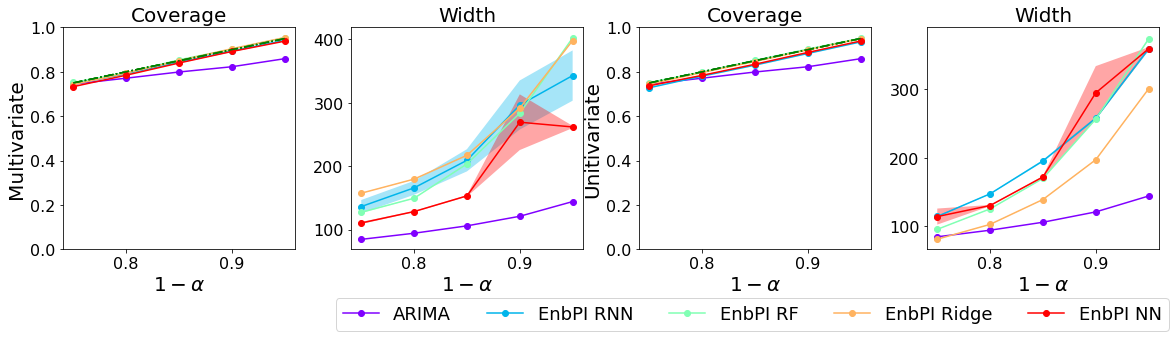

In [ ]:
alpha_ls = np.linspace(0.05, 0.25, 5)
x_axis = 1-alpha_ls
x_axis_name = 'alpha'
two_rows = False
for dataname in Data_name:
    util.plot_average_new(x_axis, x_axis_name, Dataname=[dataname], two_rows=two_rows)

## Figure 2: Marginal Coverage, change training size $T$

### Code Execution

In [ ]:
for one_dim in [True, False]:
    methods = ['Ensemble', 'ICP', 'Weighted_ICP']
    # Run Ridge, Lasso, RF, and NN
    for data_name in Data_name:
        data = eval(f'data{data_name}')  # Pandas DataFrame
        data_x = data.loc[:, data.columns != response_ls[data_name]]
        data_y = data[response_ls[data_name]]
        data_x_numpy = data_x.to_numpy()  # Convert to numpy
        data_y_numpy = data_y.to_numpy()  # Convert to numpy
        total_data_points = data_x_numpy.shape[0]
        Train_size = np.linspace(0.1 * total_data_points,
                                 0.3 * total_data_points, 10).astype(int)
        Train_size = [Train_size[0], Train_size[4], Train_size[8]]
        results = pd.DataFrame(columns=['itrial', 'dataname', 'muh_fun',
                                        'method', 'train_size', 'coverage', 'width'])
        for itrial in range(tot_trial):
            np.random.seed(98765 + itrial)
            for train_size in Train_size:
                nnet = util.keras_mod()  # Note, this is necessary because a model may "remember the past"
                rnnet = util.keras_rnn()
                print(f'At trial # {itrial} and train_size={train_size}')
                print(f'For {data_name}')
                if energy_data:
                    X_train, X_predict, Y_train, Y_predict = big_transform(
                        Data_name, data_name, one_dim, train_size)
                else:
                    X_train = data_x_numpy[:train_size, :]
                    X_predict = data_x_numpy[train_size:, :]
                    Y_train = data_y_numpy[:train_size]
                    Y_predict = data_y_numpy[train_size:]
                    if one_dim:
                        X_train, X_predict, Y_train, Y_predict = one_dimen_transform(
                            Y_train, Y_predict, d=20)
                ridge_results = prediction_interval(
                    ridge_cv, X_train, X_predict, Y_train, Y_predict)
                rf_results = prediction_interval(
                    random_forest,  X_train, X_predict, Y_train, Y_predict)
                nn_results = prediction_interval(
                    nnet,  X_train, X_predict, Y_train, Y_predict)
                if rnn:
                    T, k = X_train.shape
                    T1 = X_predict.shape[0]
                    X_train = X_train.reshape((T, 1, k))
                    X_predict = X_predict.reshape((T1, 1, k))
                    rnn_results = prediction_interval(
                        rnnet, X_train, X_predict, Y_train, Y_predict)
                # For CP Methods
                print(f'regressor is {ridge_cv.__class__.__name__}')
                result_ridge = ridge_results.run_experiments(
                    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                print(f'regressor is {random_forest.__class__.__name__}')
                result_rf = rf_results.run_experiments(
                    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                print(f'regressor is {nnet.name}')
                result_nn = nn_results.run_experiments(
                    alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                result_nn['muh_fun'] = 'NeuralNet'
                if rnn:
                    print(f'regressor is {rnnet.name}')
                    result_rnn = rnn_results.run_experiments(
                        alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods)
                    result_rnn['muh_fun'] = 'RNN'
                    results = pd.concat([results, result_ridge, result_rf, result_nn, result_rnn])
                else:
                    results = pd.concat([results, result_ridge, result_rf, result_nn])
                if one_dim:
                    results.to_csv(
                        f'Results/{data_name}_many_train_new_1d.csv', index=False)
                else:
                    results.to_csv(
                        f'Results/{data_name}_many_train_new.csv', index=False)

### Plot

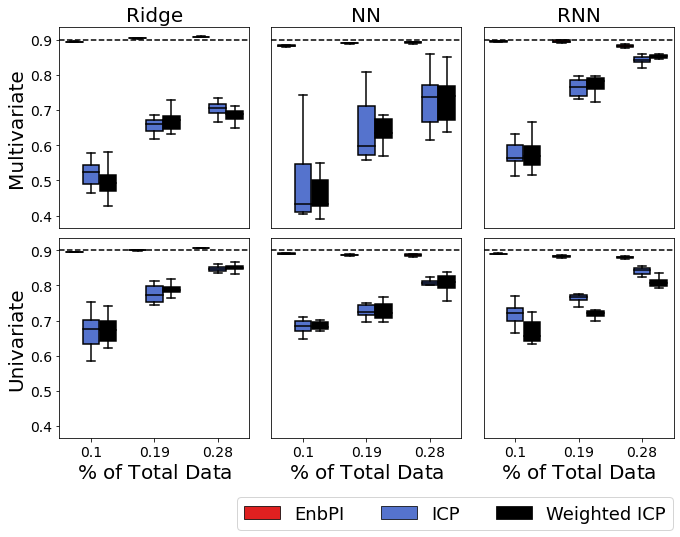

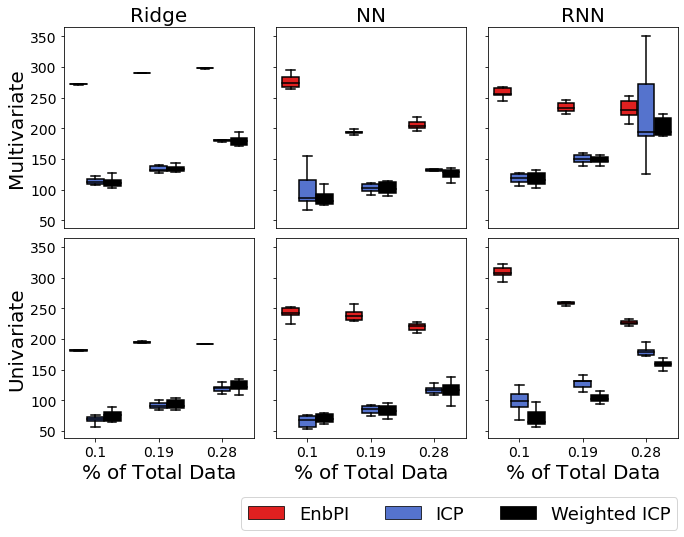

In [ ]:
for data_name in Data_name:
    util.grouped_box_new(data_name, 'coverage')
    util.grouped_box_new(data_name, 'width')

## Figure 3: Conditional coverage (with missing data)

### Define Necessary Functions

In [ ]:
def missing_data(data, missing_frac, update=False):
    n = len(data)
    idx = np.random.choice(n, size=int(missing_frac*n), replace=False)
    if update:
        data = np.delete(data, idx, 0)
    idx = idx.tolist()
    return (data, idx)


def restructure_X_t(darray):
    '''
    For each row i after the first row, take i-1 last entries of the first row and then impute the rest
    Imputation is just generating random N(Y_train_mean, Y_train_std), where
    Y_train is the first row.
    '''
    s = darray.shape[1]
    copy = np.copy(darray)
    for i in range(1, min(s, darray.shape[0])):
        copy[i, :s-i] = copy[0, i:]
        imputed_val = np.abs(np.random.normal(loc=np.mean(
            copy[0]), scale=np.std(copy[0]), size=i))
        copy[i, s-i:] = imputed_val
    return copy


def further_preprocess(data, response_name='DHI'):
    '''Extract non-zero hours and also hours between 10AM-2PM (where radiation is high) '''
    max_recorder = pd.DataFrame(np.zeros(24), index=range(0, 24))
    for i in range(0, 24):
        # Check at what times max recording is 0 (meaning no recording yet)
        time = np.arange(365)*24+i  # 12:00 AM every day. for every later hour, + i \in \{1,...,23\}
        max_record = np.max(data[response_name][time])
        max_recorder.iloc[i] = max_record
    # Drop these non-zero things
    data_sub = data.copy()
    to_be_droped = np.where(max_recorder == 0)[0]
    print(to_be_droped)
    drop_idx = []
    if len(to_be_droped) > 0:
        for i in to_be_droped:
            drop_idx.append(np.arange(365)*24+i)
        drop_idx = np.hstack(drop_idx)
        data_sub.drop(drop_idx, inplace=True)
    else:
        data_sub = []
    # Create near_noon data between 10AM-2PM
    to_be_included = np.array([10, 11, 12, 13, 14])
    to_be_droped = np.delete(np.arange(24), to_be_included)
    data_near_noon = data.copy()
    drop_idx = []
    for i in to_be_droped:
        drop_idx.append(np.arange(365)*24+i)
    drop_idx = np.hstack(drop_idx)
    data_near_noon.drop(drop_idx, inplace=True)
    return [data_sub, data_near_noon]


def big_transform_s_beyond_1(sub, cities, current_city, one_dim, missing, miss_frac=0.25):
    '''Overall, include ALL other cities' data in the CURRENT city being considered.
       1. Check what data is used (full, sub, or near-noon), need sub, but it is now suppressed.
       # NOTE, 1 is suppressed for now, since we are uncertain whether sub or near-noon is needed for Californian results
       2. If missing, process these training and testing data before transform
       -->> Current city and neighbors are assumed to have DIFFERENT missing fractions.
       3. Then, if one_dim, transform data (include past), but since s>1, apply *restructure_X_t* to s rows a time'''
    big_X_train = []
    big_X_predict = []
    for city in cities:
        print(city)
        # Start 1
        data_full = eval(f'data{city}')  # Pandas DataFrame
        if city == 'Wind_Austin':
            data_sub, data_near_noon = further_preprocess(data_full, response_name='MWH')
        else:
            data_sub, data_near_noon = further_preprocess(data_full)
        if sub == 0:
            data = data_full
            stride = 24
        elif sub == 1:
            data = data_sub
            stride = int(len(data)/365)
        else:
            data = data_near_noon
            stride = 5
        train_size = 92*stride
        col_name = 'MWH' if city == 'Wind_Austin' else 'DHI'
        data_x = data.loc[:, data.columns != col_name]
        data_y = data[col_name]
        data_x_numpy = data_x.to_numpy()  # Convert to numpy
        data_y_numpy = data_y.to_numpy()  # Convert to numpy
        X_train = data_x_numpy[:train_size, :]
        X_predict = data_x_numpy[train_size:, :]
        Y_train_del = data_y_numpy[:train_size]
        Y_predict_del = data_y_numpy[train_size:]
        # Finish 1
        # Start 2
        if missing:
            X_train, miss_train_idx = missing_data(
                X_train, missing_frac=miss_frac, update=True)
            Y_train_del = np.delete(Y_train_del, miss_train_idx)
            Y_predict_del, miss_test_idx = missing_data(
                Y_predict_del, missing_frac=miss_frac, update=False)
            if city == current_city:
                # Need an additional Y_truth
                Y_train = Y_train_del
                Y_predict = Y_predict_del.copy()
                true_miss_text_idx = miss_test_idx
            Y_predict_del[miss_test_idx] = np.abs(np.random.normal(loc=np.mean(
                Y_train_del), scale=np.std(Y_train_del), size=len(miss_test_idx)))

        else:
            true_miss_text_idx = []
            if city == current_city:
                Y_train = Y_train_del
                Y_predict = Y_predict_del
        # Finish 2
        # Start 3
        if one_dim:
            X_train, X_predict, Y_train_del, Y_predict_del = one_dimen_transform(
                Y_train_del, Y_predict_del, d=min(stride, 24))  # Note: this handles 'no_slide (stride=infty)' case
            j = 0
            for k in range(len(X_predict)//stride+1):
                X_predict[j*k:min((j+1)*k, len(X_predict))
                          ] = restructure_X_t(X_predict[j*k:min((j+1)*k, len(X_predict))])
                j += 1
            big_X_train.append(X_train)
            big_X_predict.append(X_predict)
            if city == current_city:
                Y_train = Y_train_del
        else:
            big_X_train.append(X_train)
            big_X_predict.append(X_predict)
        # Finish 3
    X_train = np.abs(np.hstack(big_X_train))
    X_predict = np.abs(np.hstack(big_X_predict))
    return([X_train, X_predict, Y_train, Y_predict, true_miss_text_idx, stride])


def all_together(Data_name, sub, no_slide, missing, miss_frac=0.25, one_dim=False):
    methods = ['Ensemble']
    train_days = 92
    density_est = False
    itrial = 1
    results_ls = {}
    alpha = 0.1
    B = np.random.binomial(100, np.exp(-1))  # number of bootstrap samples
    for data_name in Data_name:
        np.random.seed(98765)
        # nnet = util.keras_mod()  # Note, this is necessary because a model may "remember the past"
        X_train, X_predict, Y_train, Y_predict, miss_test_idx, stride = big_transform_s_beyond_1(
            sub, Data_name, data_name, one_dim, missing)
        train_size = 92*stride
        print(f'At train_size={train_size}')
        print(f'For {data_name}')
        if no_slide:
            stride = int((365-92)*stride)  # No slide at all
        print(stride)
        nnet = util.keras_mod()
        min_alpha = 0.0001
        max_alpha = 10
        ridge_cv = RidgeCV(alphas=np.linspace(min_alpha, max_alpha, 10))
        random_forest = RandomForestRegressor(n_estimators=10, criterion='mse',
                                              bootstrap=False, max_depth=2, n_jobs=-1)
        ridge_results = prediction_interval(
            ridge_cv, X_train, X_predict, Y_train, Y_predict)
        rf_results = prediction_interval(
            random_forest,  X_train, X_predict, Y_train, Y_predict)
        nn_results = prediction_interval(
            nnet,  X_train, X_predict, Y_train, Y_predict)
        # For CP Methods
        print(f'regressor is {ridge_cv.__class__.__name__}')
        result_ridge = ridge_results.run_experiments(
            alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods, get_plots=True)
        print(f'regressor is {random_forest.__class__.__name__}')
        result_rf = rf_results.run_experiments(
            alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods, get_plots=True)
        print(f'regressor is {nnet.name}')
        result_nn = nn_results.run_experiments(
            alpha, B, stride, data_name, itrial, miss_test_idx, methods=methods, get_plots=True)
        results_ls[data_name] = [result_ridge, result_rf, result_nn, stride, Y_predict]
    return results_ls

### Code Execution and Plot

In [ ]:
ATL_cities = ['Solar_Atl']
max_data_size = 10000
dataSolar_Atl = util.read_data(3, 'Data/Solar_Atl_data.csv', max_data_size)
# Get results
results_ls_with_missing_and_slide_sub = all_together(
    Data_name=ATL_cities, sub=1, no_slide=False, missing=True, one_dim=False)

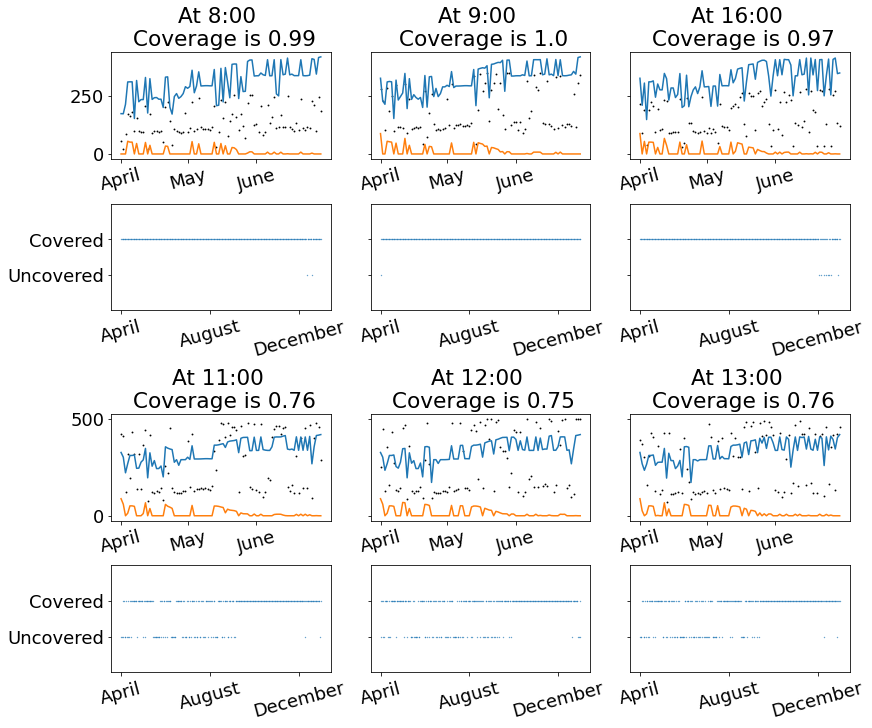

In [ ]:
# Make plots
Data_name=ATL_cities
util.make_cond_plots(Data_name, results_ls_with_missing_and_slide_sub,
                     no_slide=False, missing=True, one_d=False, five_in_a_row=False, only_RF=True)

## Figure 4: Anomaly Detection (**ECAD**)

Note that this part is rather separated from above, because the detector **ECAD** is a modification of **EnbPI$$. We re-load modules for self-contained demonstration.

Also note that, due to the size of dataset (150MB), we do not upload it here. Please download it from https://www.kaggle.com/mlg-ulb/creditcardfraud and save as "Money_Laundry.csv" in the *Data* repository.

In [ ]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from pyod.models.knn import KNN   # kNN detector
# HBOS: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.hbos
from pyod.models.hbos import HBOS
# IForest: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.iforest
from pyod.models.iforest import IForest
# OCSVM https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.ocsvm
from pyod.models.ocsvm import OCSVM
# PCA: https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.pca
from pyod.models.pca import PCA
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import utils_ECAD as AD_algos

### Define Necessary Functions

In [ ]:
'''Get data and downsample'''


def get_data_and_true_abnormal(tot_len):
    dataset = pd.read_csv('Data/Money_Laundry.csv', nrows=tot_len)
    dataset.drop('Time', axis=1, inplace=True)
    true_abnormal = np.where(dataset.Class == 1)[0]
    return dataset, true_abnormal


def get_downsample_data(data, train_size):
    data_x = data.iloc[:, :-1]
    data_y = data.iloc[:, -1]
    data_x_numpy = data_x.to_numpy()  # Convert to numpy
    data_y_numpy = data_y.to_numpy()  # Convert to numpy
    X_train = data_x_numpy[:train_size, :]
    X_predict = data_x_numpy[train_size:, :]
    Y_train = data_y_numpy[:train_size]
    Y_predict = data_y_numpy[train_size:]
    train_abnormal = np.where(Y_train == 1)[0]
    train_normal = np.where(Y_train == 0)[0]
    X_train_abnormal = X_train[train_abnormal, :]
    Y_train_abnormal = Y_train[train_abnormal]
    down_sample_idx = np.random.choice(train_normal, 5*len(train_abnormal), replace=False)
    X_train_normal = X_train[down_sample_idx, :]
    Y_train_normal = Y_train[down_sample_idx]
    X_train = np.vstack((X_train_abnormal, X_train_normal))
    Y_train = np.hstack((Y_train_abnormal, Y_train_normal))
    return (X_train, X_predict, Y_train, Y_predict)


'''(For final results) Put everything together (with competing methods)'''

'''First define functions'''
# Competing methods


def mod_to_result(regr_name, X_train, Y_train, test_true_abnormal):
    mod = eval(regr_name)
    mod.fit(X_train, Y_train)
    est_anomalies = mod.predict(X_predict)
    est_anomalies = np.where(est_anomalies == 1)[0]
    precision, recall, F1 = AD_algos.accuracies(
        est_anomalies, test_true_abnormal)
    return [precision, recall, F1]

def ECAD(tot_size, train_frac):
    data, true_abnormal = get_data_and_true_abnormal(tot_size)
    data.shape
    train_size = int(data.shape[0]*train_frac)
    train_size  # A lot of anomalies occurred around 6000
    neighbor_size = 5  # for each abnormal idx in training, how many of its neighbors are used in calibrating residuals
    alpha = np.linspace(0.05, 0.15, 3)  # @ 0.005, ~80/60/70. @ 0.1, almost exactly the same
    alpha = [0.05]
    dotted = True
    stride = 1  # A large stride, suitable when training data is large (so less percentile needed)
    # NOTE: actual getting residual part is the most expensive (since iterate through n...)
    # Thus, let n be even smaller
    return_fitted = False
    est_anomalies = AD_algos.get_anomalies_classification(
        data, 'RF', train_size, alpha,  stride, dotted, return_fitted=return_fitted, neighbor_size=neighbor_size)
    if len(alpha) > 1:
        AD_algos.PR_curve(est_anomalies, true_abnormal[true_abnormal > train_size]-train_size)
    else:
        precision, recall, F1 = AD_algos.accuracies(
            est_anomalies[0], true_abnormal[true_abnormal > train_size]-train_size)
        return [precision, recall, F1]

### Code Execution and Plot

In [ ]:
tot_trial = 1
train_fracs = np.linspace(0.3, 0.7, 5)
tot_size = 284807
methods = ['ECAD', 'HBOS()', 'IForest()', 'OCSVM()', 'PCA()', 'svm.SVC(gamma="auto")', 'GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)',
           'neighbors.KNeighborsClassifier(n_neighbors=20, weights="distance")', 'MLPClassifier(solver="lbfgs", alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)']
method_name = {'ECAD': 'ECAD', 'HBOS()': 'HBOS', 'IForest()': 'IForest', 'OCSVM()': "OCSVM", 'PCA()': 'PCA', 'svm.SVC(gamma="auto")': 'SVC', 'GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)': 'GBoosting',
               'neighbors.KNeighborsClassifier(n_neighbors=20, weights="distance")': 'KNN', 'MLPClassifier(solver="lbfgs", alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)': 'MLPClassifer'}
results = pd.DataFrame(columns=['itrial', 'train_frac', 'method',
                                'precision', 'recall', 'F1'])
for itrial in range(tot_trial):
    np.random.seed(98765+itrial)
    for train_frac in train_fracs:
        train_frac = np.round(train_frac, 2)
        data, true_abnormal = get_data_and_true_abnormal(tot_size)
        train_size = int(tot_size*train_frac)
        X_train, X_predict, Y_train, _ = get_downsample_data(data, train_size)
        test_true_abnormal = true_abnormal[true_abnormal > train_size]-train_size
        for method in methods:
            if method == 'ECAD':
                precision, recall, F1 = ECAD(tot_size, train_frac)
            else:
                precision, recall, F1 = mod_to_result(method, X_train, Y_train, test_true_abnormal)
            results.loc[len(results)] = [itrial, train_frac,
                                         method_name[method], precision, recall, F1]
            results.to_csv(f'Results/Kaggle_results.csv', index=False)

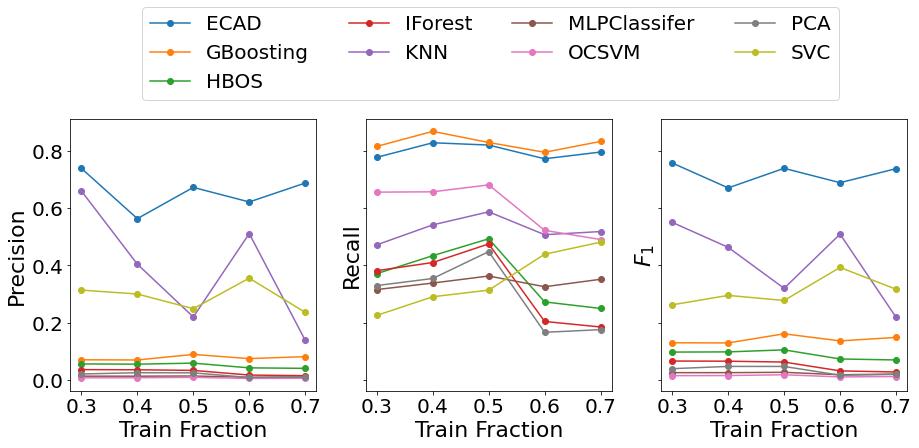

In [ ]:
# Plot
results = pd.read_csv('Results/Kaggle_results.csv')
AD_algos.plt_prec_recall_F1(results)